In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [5]:
from preprocessing import *
data_path = "data/game.csv"
X_train, X_test, y_train, y_test = prep_all(data_path)

X_train = X_train.values.reshape(-1, 1, 135)  # Reshape to (32520, 1, 136)
X_test = X_test.values.reshape(-1, 1, 135)    # Reshape to (N, 1, 136), where N is the number of test samples

train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train.to_numpy()))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test.to_numpy()))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(test_data, batch_size=64, shuffle=False)

/Users/spencer/Desktop/Repos/nba-predictor/preprocessing.py:43: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['matchup', 'team_abbreviation', 'team_name', 'wl'], dtype='object')
  rolling_averages = grouped[columns_to_average].apply(lambda x: x.rolling(window=len(x), min_periods=1).mean().shift(1))
/Users/spencer/Desktop/Repos/nba-predictor/preprocessing.py:43: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  rolling_averages = grouped[columns_to_average].apply(lambda x: x.rolling

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out


In [7]:
input_size = X_train.shape[2]  # The number of features in your preprocessed data
output_size = 2  # Win or loss (binary classification)

model = LogisticRegressionModel(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 200
losses= []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.squeeze(1).float(), labels.long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/200], Loss: 0.6497
Epoch [2/200], Loss: 0.5836
Epoch [3/200], Loss: 0.5485
Epoch [4/200], Loss: 0.5481
Epoch [5/200], Loss: 0.5685
Epoch [6/200], Loss: 0.5129
Epoch [7/200], Loss: 0.5775
Epoch [8/200], Loss: 0.5799
Epoch [9/200], Loss: 0.5695
Epoch [10/200], Loss: 0.5537
Epoch [11/200], Loss: 0.5964
Epoch [12/200], Loss: 0.5407
Epoch [13/200], Loss: 0.4929
Epoch [14/200], Loss: 0.5031
Epoch [15/200], Loss: 0.6443
Epoch [16/200], Loss: 0.5768
Epoch [17/200], Loss: 0.6452
Epoch [18/200], Loss: 0.7174
Epoch [19/200], Loss: 0.6344
Epoch [20/200], Loss: 0.4496
Epoch [21/200], Loss: 0.6398
Epoch [22/200], Loss: 0.5958
Epoch [23/200], Loss: 0.6162
Epoch [24/200], Loss: 0.5545
Epoch [25/200], Loss: 0.5770
Epoch [26/200], Loss: 0.6172
Epoch [27/200], Loss: 0.6394
Epoch [28/200], Loss: 0.6785
Epoch [29/200], Loss: 0.6399
Epoch [30/200], Loss: 0.6027
Epoch [31/200], Loss: 0.6332
Epoch [32/200], Loss: 0.5367
Epoch [33/200], Loss: 0.6366
Epoch [34/200], Loss: 0.7673
Epoch [35/200], Loss: 0

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 67.33%


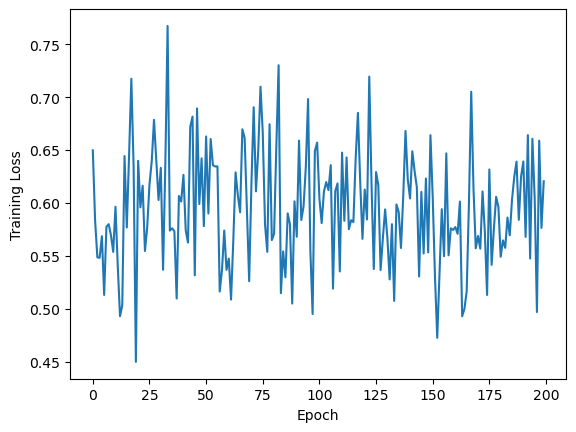

In [10]:
# Plot the loss function
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.savefig('plots/results/logisticregression.png')


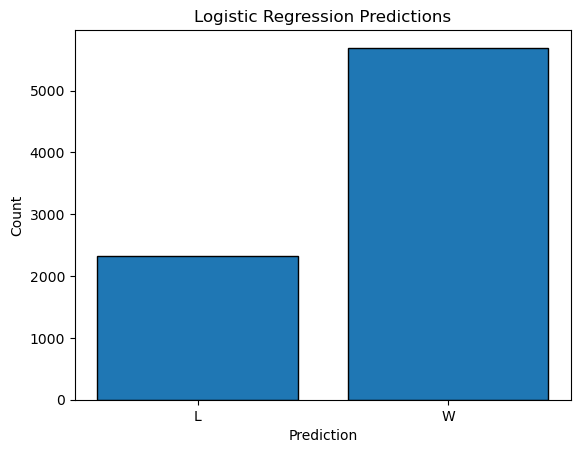

In [15]:
# Histogram of predictions
with torch.no_grad():
    predictions = []
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions += predicted.tolist()

    plt.hist(predictions, bins=[0, 1, 2], align='left', rwidth=0.8, edgecolor='black')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Logistic Regression Predictions')
    plt.xticks([0, 1], ['L', 'W'])
    plt.savefig('plots/results/logisticregression_hist.png')


In [12]:
input_size = X_train.shape[2]  # The number of features in your preprocessed data
output_size = 2  # Win or loss (binary classification)

model = LogisticRegressionModel(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
num_epochs = 200
losses= []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.squeeze(1).float(), labels.long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 0.7653
Epoch [2/200], Loss: 0.6000
Epoch [3/200], Loss: 0.6574
Epoch [4/200], Loss: 0.6080
Epoch [5/200], Loss: 0.6173
Epoch [6/200], Loss: 0.6817
Epoch [7/200], Loss: 0.5471
Epoch [8/200], Loss: 0.6873
Epoch [9/200], Loss: 0.6395
Epoch [10/200], Loss: 0.6055
Epoch [11/200], Loss: 0.5962
Epoch [12/200], Loss: 0.5946
Epoch [13/200], Loss: 0.5773
Epoch [14/200], Loss: 0.6456
Epoch [15/200], Loss: 0.6297
Epoch [16/200], Loss: 0.6061
Epoch [17/200], Loss: 0.8013
Epoch [18/200], Loss: 0.6130
Epoch [19/200], Loss: 0.5925
Epoch [20/200], Loss: 0.6251
Epoch [21/200], Loss: 0.7741
Epoch [22/200], Loss: 0.5751
Epoch [23/200], Loss: 0.6685
Epoch [24/200], Loss: 0.6835
Epoch [25/200], Loss: 0.6916
Epoch [26/200], Loss: 0.6792
Epoch [27/200], Loss: 0.5665
Epoch [28/200], Loss: 0.6399
Epoch [29/200], Loss: 0.7389
Epoch [30/200], Loss: 0.6722
Epoch [31/200], Loss: 0.5003
Epoch [32/200], Loss: 0.6236
Epoch [33/200], Loss: 0.6593
Epoch [34/200], Loss: 0.6777
Epoch [35/200], Loss: 0

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.squeeze(1).float(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 66.33%
